In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization


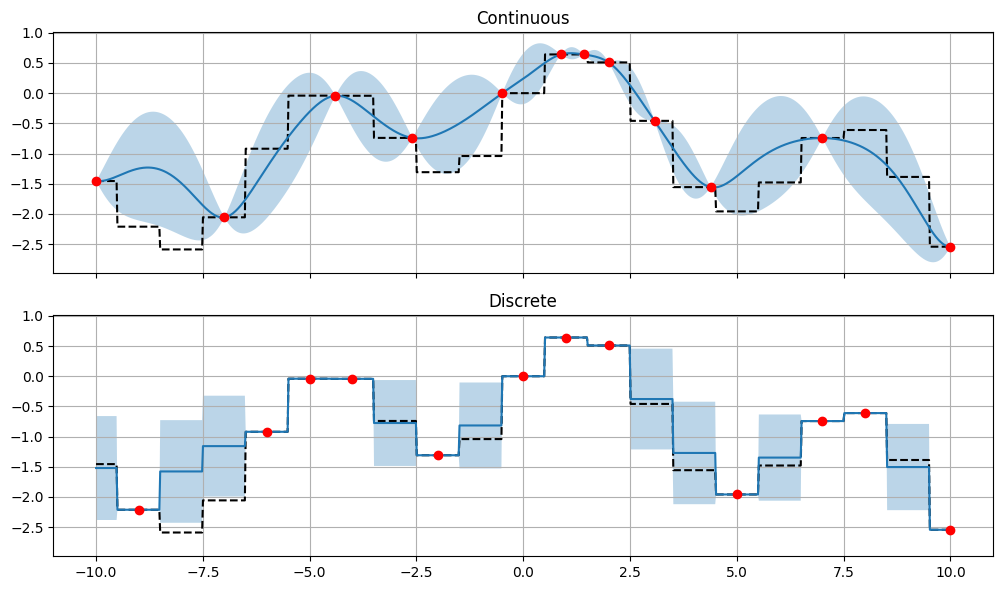

In [2]:
def target_function_1d(x):
    return np.sin(np.round(x)) - np.abs(np.round(x) / 5)

c_pbounds = {'x': (-10, 10)}
bo_cont = BayesianOptimization(target_function_1d, c_pbounds, verbose=0)

d_pbounds = {'x': (-10, 10, int)}
bo_disc = BayesianOptimization(target_function_1d, d_pbounds, verbose=0)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)

bo_cont.maximize(init_points=2, n_iter=10)
bo_cont.acquisition_function._fit_gp(bo_cont._gp, bo_cont.space)

y_mean, y_std = bo_cont._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[0].set_title('Continuous')
axs[0].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[0].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[0].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[0].plot(bo_cont.space.params, bo_cont.space.target, 'ro')

bo_disc.maximize(init_points=2, n_iter=10)
bo_disc.acquisition_function._fit_gp(bo_disc._gp, bo_disc.space)

y_mean, y_std = bo_disc._gp.predict(np.linspace(-10, 10, 1000).reshape(-1, 1), return_std=True)
axs[1].set_title('Discrete')
axs[1].plot(np.linspace(-10, 10, 1000), target_function_1d(np.linspace(-10, 10, 1000)), 'k--', label='True function')
axs[1].plot(np.linspace(-10, 10, 1000), y_mean, label='Predicted mean')
axs[1].fill_between(np.linspace(-10, 10, 1000), y_mean - y_std, y_mean + y_std, alpha=0.3, label='Predicted std')
axs[1].plot(bo_disc.space.params, bo_disc.space.target, 'ro')

for ax in axs:
    ax.grid(True)
fig.tight_layout()

In [3]:
# We can see, that the discrete optimizer is aware that the function is discrete and does not try to predict values
# between the integers. The continuous optimizer tries to predict values between the integers, despite the fact that these are known.
# We can also see that the discrete optimizer predicts blocky mean and standard deviations, which is a result of the discrete nature of the function.

In [4]:
def discretized_function(x, y):
    y = np.round(y)
    return (-1*np.cos(x)**np.abs(y) + -1*np.cos(y)) + 0.1 * (x + y) - 0.01 * (x**2 + y**2)

In [5]:
# Bounded region of parameter space
c_pbounds = {'x': (-5, 5), 'y': (-5, 5)}

In [6]:
labels = ["All-float Optimizer", "Typed Optimizer"]

In [7]:
continuous_optimizer = BayesianOptimization(
    f=discretized_function,
    #acquisition_function=acquisition.ExpectedImprovement(xi=1., random_state=42),
    pbounds=c_pbounds,
    verbose=2,
    random_state=42,
)


d_pbounds = {'x': (-5, 5), 'y': (-5, 5, int)}
discrete_optimizer = BayesianOptimization(
    f=discretized_function,
    #acquisition_function=acquisition.ExpectedImprovement(xi=1., random_state=42),
    pbounds=d_pbounds,
    verbose=2,
    random_state=42,
)
#discrete_optimizer.set_gp_params(alpha=1e-3)

In [8]:
for lbl, optimizer in zip(labels, [continuous_optimizer, discrete_optimizer]):
    print(f"====================  {lbl}  ====================\n")
    optimizer.maximize(
        init_points=2,
        n_iter=13
    )
    print(f"Max: {optimizer.max['target']}\n\n")

====================  All-float Optimizer  ====================

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.1778   | -1.254598 | 4.5071430 |
| 2         | 0.4089    | 2.3199394 | 0.9865848 |
| 3         | -1.787    | 3.0783145 | -0.082060 |
| 4         | 0.7095    | 1.5913220 | 1.8823587 |
| 5         | -0.09673  | 2.7779629 | 2.3840590 |
| 6         | -1.034    | 0.8481708 | 0.8669483 |
| 7         | 1.277     | 1.2462273 | 3.1071194 |
| 8         | 0.9953    | 1.261569  | 4.2461872 |
| 9         | 0.3207    | 0.2574759 | 3.3743200 |
| 10        | 0.7984    | 2.3822527 | 4.0972752 |
| 11        | 0.2769    | 4.0866405 | 4.9990993 |
| 12        | -1.783    | -4.990362 | -4.900993 |
| 13        | -0.2363   | -4.975007 | 1.5082626 |
| 14        | 0.1458    | 2.0323084 | 4.9763438 |
| 15        | 1.374     | 1.8577640 | 3.3266304 |
Max: 1.3739320944970081


====================  Typed Optimizer  ====================

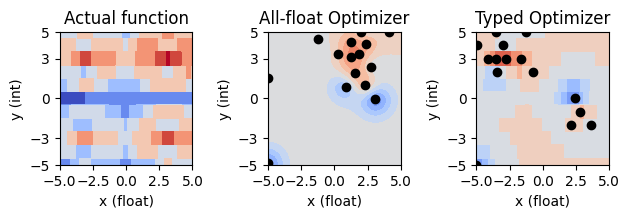

In [9]:
x = np.linspace(c_pbounds['x'][0], c_pbounds['x'][1], 1000)
y = np.linspace(c_pbounds['y'][0], c_pbounds['y'][1], 1000)

X, Y = np.meshgrid(x, y)

Z = discretized_function(X, Y)

params = [{'x': x_i, 'y': y_j} for y_j in y for x_i in x]
array_params = [continuous_optimizer._space.params_to_array(p) for p in params]
c_pred = continuous_optimizer._gp.predict(array_params).reshape(X.shape)
d_pred = discrete_optimizer._gp.predict(array_params).reshape(X.shape)

vmin = np.min([np.min(Z), np.min(c_pred), np.min(d_pred)])
vmax = np.max([np.max(Z), np.max(c_pred), np.max(d_pred)])

fig, axs = plt.subplots(1, 3)

axs[0].set_title('Actual function')
axs[0].contourf(X, Y, Z, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)


axs[1].set_title(labels[0])
axs[1].contourf(X, Y, c_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[1].scatter(continuous_optimizer._space.params[:,0], continuous_optimizer._space.params[:,1], c='k')

axs[2].set_title(labels[1])
axs[2].contourf(X, Y, d_pred, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
axs[2].scatter(discrete_optimizer._space.params[:,0], discrete_optimizer._space.params[:,1], c='k')


def make_plot_fancy(ax: plt.Axes):
    ax.set_aspect("equal")
    ax.set_xlabel('x (float)')
    ax.set_xticks([-5.0, -2.5, 0., 2.5, 5.0])
    ax.set_ylabel('y (int)')
    ax.set_yticks([-5, -3, 0, 3, 5])

for ax in axs:
    make_plot_fancy(ax)

plt.tight_layout()
plt.show()

## 3. Categorical variables


In [10]:
def f1(x1, x2):
    return -1*(x1 - np.sqrt(x1**2 + x2**2) * np.cos(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def f2(x1, x2):
    return -1*(x2 - np.sqrt(x1**2 + x2**2) * np.sin(np.sqrt(x1**2 + x2**2))**2 + 0.5 * np.sqrt(x1**2 + x2**2))

def SPIRAL(x1, x2, k):
    """cf Ladislav-Luksan
    """
    if k=='1':
        return f1(x1, x2)
    elif k=='2':
        return f2(x1, x2)


In [11]:
pbounds = {'x1': (-10, 10), 'x2': (-10, 10), 'k': ('1', '2')}

categorical_optimizer = BayesianOptimization(
    f=SPIRAL,
    #acquisition_function=acquisition.ExpectedImprovement(1e-2),
    pbounds=pbounds,
    verbose=2,
    random_state=42,
)
discrete_optimizer.set_gp_params(alpha=1e-3)

categorical_optimizer.maximize(
        init_points=2,
        n_iter=18,
    )

|   iter    |  target   |     k     |    x1     |    x2     |
-------------------------------------------------------------
| 1         | -5.62     | 1         | 5.9308597 | -6.331304 |
| 2         | 7.509     | 2         | 1.9731696 | -6.879627 |
| 3         | 8.825     | 2         | 1.1484948 | -7.207232 |
| 4         | -3.945    | 1         | 1.4977824 | -8.189324 |
| 5         | 1.978     | 1         | 1.0306587 | -6.389038 |
| 6         | 8.229     | 2         | 1.3033840 | -7.107783 |
| 7         | 9.632     | 2         | -0.198942 | -7.391484 |
| 8         | 11.54     | 2         | -1.136689 | -7.696695 |
| 9         | 7.76      | 2         | -1.535976 | -7.007879 |
| 10        | -0.5064   | 1         | -1.153247 | -8.358024 |
| 11        | 9.011     | 2         | -0.860207 | -7.266433 |
| 12        | -1.8      | 1         | -1.227306 | -7.434615 |
| 13        | 4.911     | 1         | -1.825508 | -6.159445 |
| 14        | 11.25     | 2         | -0.643026 | -7.648759 |
| 15    

In [12]:
res = categorical_optimizer._space.res()
k1 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='1'])
k2 = np.array([[p['params']['x1'], p['params']['x2']] for p in res if p['params']['k']=='2'])

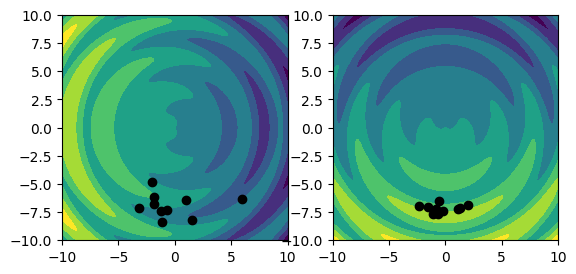

In [13]:
x1 = np.linspace(pbounds['x1'][0], pbounds['x1'][1], 1000)
x2 = np.linspace(pbounds['x2'][0], pbounds['x2'][1], 1000)

X1, X2 = np.meshgrid(x1, x2)
Z1 = SPIRAL(X1, X2, '1')
Z2 = SPIRAL(X1, X2, '2')

fig, axs = plt.subplots(1, 2)

vmin = np.min([np.min(Z1), np.min(Z2)])
vmax = np.max([np.max(Z1), np.max(Z2)])

axs[0].contourf(X1, X2, Z1, vmin=vmin, vmax=vmax)
axs[0].set_aspect("equal")
axs[0].scatter(k1[:,0], k1[:,1], c='k')
axs[1].contourf(X1, X2, Z2, vmin=vmin, vmax=vmax)
axs[1].scatter(k2[:,0], k2[:,1], c='k')
axs[1].set_aspect("equal")


## 4. Use in ML

In [14]:
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

data = load_breast_cancer()
X_train, y_train = data['data'], data['target']
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
kernels = ['rbf', 'poly']

def f_target(kernel, log10_C):
    if kernel == 'poly2':
        kernel = 'poly'
        degree = 2
    elif kernel == 'poly3':
        kernel = 'poly'
        degree = 3
    elif kernel == 'rbf':
        degree = 3 # not used, equal to default

    C = 10**log10_C

    model = SVC(C=C, kernel=kernel, degree=degree, probability=True, random_state=42)
    model.fit(X_train, y_train)

    # Package looks for maximum, so we return -1 * log_loss
    loss = -1 * log_loss(y_val, model.predict_proba(X_val))
    return loss


params_svm ={
    'kernel': ['rbf', 'poly2', 'poly3'],
    'log10_C':(-1, +1),
}

optimizer = BayesianOptimization(
    f_target,
    params_svm,
    #acquisition_function=acquisition.ExpectedImprovement(1e-2, random_state=42),
    random_state=42,
    verbose=2
)
discrete_optimizer.set_gp_params(alpha=1e-3)

optimizer.maximize(init_points=2, n_iter=8)

|   iter    |  target   |  kernel   |  log10_C  |
-------------------------------------------------
| 1         | -0.1446   | poly3     | 0.5930859 |
| 2         | -0.1474   | poly3     | 0.4639878 |
| 3         | -0.139    | poly3     | 0.9998496 |
| 4         | -0.139    | poly3     | 0.9994641 |
| 5         | -0.1072   | rbf       | 0.9996179 |
| 6         | -0.1607   | poly3     | -0.805461 |
| 7         | -0.1372   | poly2     | 0.0678008 |
| 8         | -0.1547   | poly3     | 0.1300376 |
| 9         | -0.1257   | rbf       | -0.162077 |
| 10        | -0.1634   | poly3     | -0.999886 |
